In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_009265, selected_008229
from imports import *
from loading import load_session_data
from target import get_spike_counts
from scipy import stats

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
sessions = [s for s in selected_008229.keys()]
sessions.sort()
sessions

['008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-18_14-36-18',
 '008229_hippoSIT_2022-05-20_15-54-39']

In [5]:
session = sessions[0]

session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
areas = session_data['areas']
aeps = session_data['aeps']
aeps_events = session_data['aeps_events']
AEP_metrics_lims = session_data['AEP_metrics_lims']
AEP_metrics_raw = session_data['AEP_metrics_raw']
AEP_metrics_norm = session_data['AEP_metrics_norm']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
animal = session_data['animal']
aeps_file = session_data['aeps_file']
h5_file = session_data['h5_file']
report_path = session_data['report_path']
session

'008229_hippoSIT_2022-05-16_20-36-44'

## Cross-AEPs

In [6]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
aeps_tl_idxs = np.array(aeps_tl_idxs)

In [7]:
# area = 'A1'
# window_l = 40  # in AEP events, 10 sec is ~40 events

# idxs_bgr = np.where(aeps_events[:, 1] == 1)[0]
# idxs_tgt = np.where(aeps_events[:, 1] == 2)[0]

# metric1 = AEP_metrics_norm[area]['N1']  #[idxs_tgt]
# metric2 = AEP_metrics_norm[area]['P3']  #[idxs_tgt]

# inst_corrs = np.zeros(len(metric1) - window_l)
# for i in range(len(inst_corrs)):
#     inst_corrs[i] = stats.pearsonr(metric1[i:i + window_l], metric2[i:i + window_l])[0]

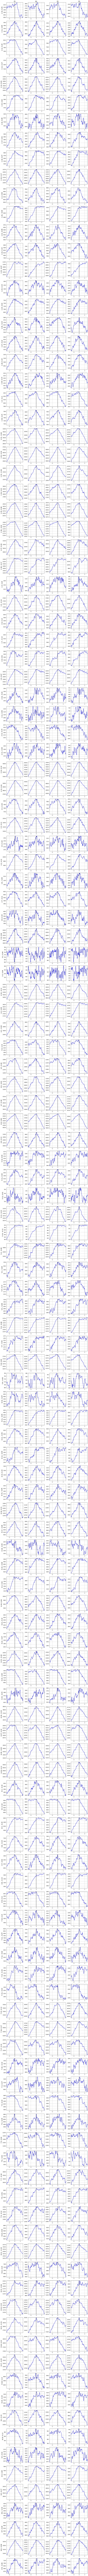

In [8]:
area = 'PPC'
to_plot = dict(list(single_units.items())[:])

fig = plt.figure(figsize=(12, 2.5*len(to_plot)))

s_rate = 100  # Hz
t_lag  = 3  # seconds
dim = len(AEP_metrics_norm[area])
speed = tl[:, 3]
bgr_aep_idxs = np.where(aeps_events[:, 1] == 1)[0]
tgt_aep_idxs = np.where(aeps_events[:, 1] == 2)[0]
    
metric_names = ['P1', 'N1', 'P2', 'P3']  # to follow the order
for i, (unit_name, i_rate) in enumerate(to_plot.items()):
    corr_coeff = stats.pearsonr(i_rate, speed)[0]
    
    #for j, (m_name, m_vals) in enumerate(AEP_metrics_norm[area].items()):
    for j, m_name in enumerate(metric_names):
        m_vals = AEP_metrics_norm[area][m_name]
        metric1 = i_rate[aeps_tl_idxs][bgr_aep_idxs]
        metric2 = m_vals[bgr_aep_idxs]
#         metric1 = i_rate[aeps_tl_idxs][:-40]
#         metric2 = inst_corrs
        
        corr = signal.correlate(metric1, metric2)
        lags = signal.correlation_lags(len(metric2), len(metric1))
        idx_l, idx_r = int(len(lags)/2) - t_lag*s_rate, int(len(lags)/2) + t_lag*s_rate
        y_min = corr[idx_l:idx_r].min()
        y_max = corr[idx_l:idx_r].max()

        ax = fig.add_subplot(len(to_plot), dim, dim*i + j+1)
        ax.plot(lags[idx_l:idx_r]/100, corr[idx_l:idx_r], color='blue')

        if i == 0:
            ax.set_title(m_name, fontsize=14)
        if j == 0:
            ax.set_ylabel("%s, %.2f" % (unit_name, corr_coeff), fontsize=14)
        ax.axvline(0, color='black')
        ax.set_xlim(-t_lag, t_lag)
        ax.set_ylim(y_min, y_max)
        ax.grid()
    
fig.tight_layout()
fig.savefig(os.path.join(report_path, 'CCR_%s_AEP_metrics.pdf' % area))

In [9]:
# single corr coef
#np.corrcoef(single_units['3-15'][aeps_tl_idxs], AEP_metrics_norm[area]['P3'])